In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Image Processing

In [4]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

# Output Folders
output_folder = 'dataset/traffic_object_detection_processed'
output_train_folder = f'{output_folder}/train'
output_test_folder = f'{output_folder}/test'
output_valid_folder = f'{output_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 255, 0], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

In [5]:
def draw_boundary(image, color, coordinates):
    x = int(coordinates[1] * image.shape[0])
    y = int(coordinates[2] * image.shape[1])
    width = int(coordinates[3] * image.shape[0])
    height = int(coordinates[4] * image.shape[1])
    image[y-height:y-height+5, x-width:x+width, :] = color
    image[y-height:y+height, x+width:x+width+5, :] = color
    image[y+height-5:y+height, x-width:x+width, :] = color
    image[y-height:y+height, x-width-5:x-width, :] = color
    return image, (int(coordinates[0]), x, y, width, height)

def clip(value, prev_min, prev_max, new_min, new_max):
    return int((((value - prev_min) * (new_max - new_min)) / (prev_max - prev_min)) + new_min)

## Data Display

aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.txt aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.jpg


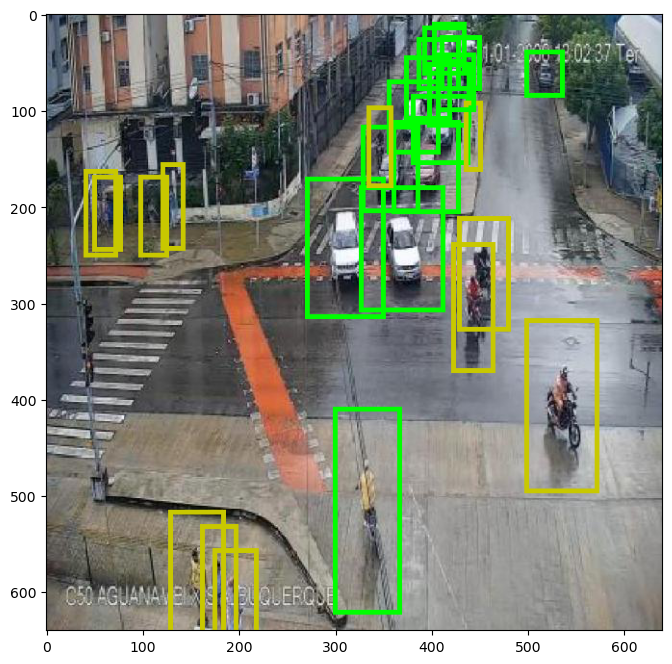

In [6]:
# Loading data
image_index = 4
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = draw_boundary(new_image, colors[int(coordinates[0])], coordinates)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

# Defining Data Generator

In [7]:
# Generates anchor points accross the image
def generate_anchor_points(image, stride = 5):
    anchor_points = []
    for i in range(stride, image.shape[0], stride):
        for j in range(stride, image.shape[1], stride):
            anchor_points.append([i, j])
    return anchor_points

def add_anchor_points(image, points, point_size = 5): 
    new_image = image.copy()
    for point in points:
        new_image[point[0] - point_size : point[0] + point_size, point[1] - point_size : point[1] + point_size, :] = [255, 255, 0]
    return new_image

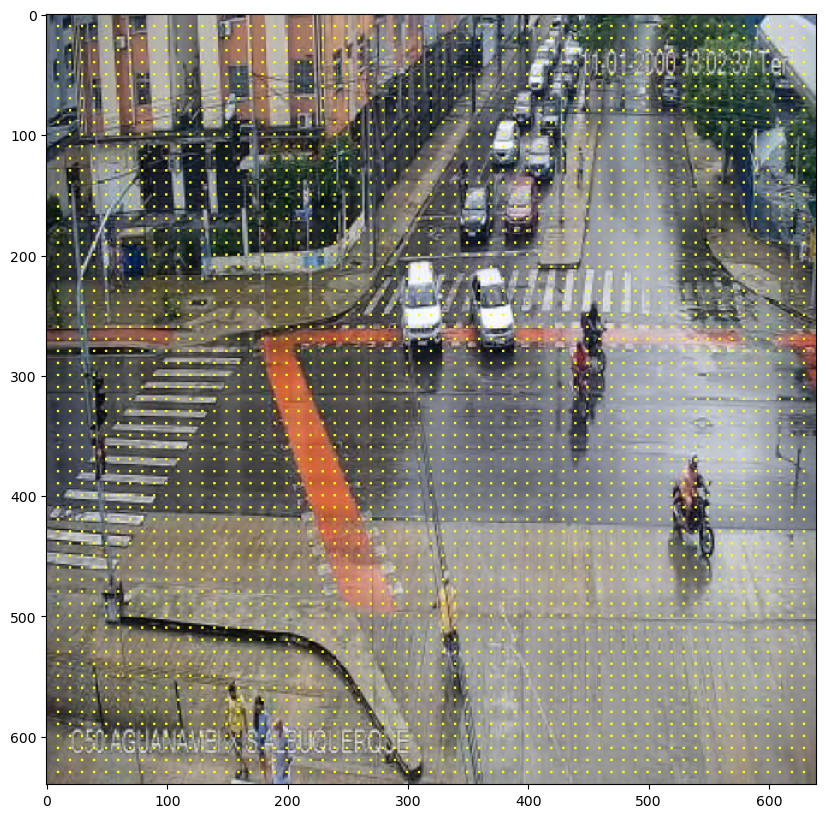

In [8]:
anchor_points = generate_anchor_points(image, 10)
anchor_points_image = add_anchor_points(image, anchor_points, 1)
plt.figure(figsize=(10, 10))
plt.imshow(anchor_points_image)

In [9]:
def generate_regions(anchor_points, region_ratios, region_scales):
    # Going for each anchor point
    regions = []
    for anchor in anchor_points:
        for ratio in region_ratios:
            for scale in region_scales:
                value = 2 * scale
                width = ratio[0] * value
                height = ratio[1] * value
                regions.append([anchor[0], anchor[1], width, height])
    return regions

def add_regions(image, regions, color=[0, 0, 0], thickness = 1):
    new_image = image.copy()
    for region in regions:
        x = region[0]
        y = region[1]
        width = region[2]
        height = region[3]
        topleft = [0 if x - width < 0 else x - width, 0 if y - height < 0 else y - height]
        topright = [image.shape[0] if x + width > image.shape[0] else  x + width, 0 if y - height < 0 else y - height]
        bottomleft = [0 if x - width < 0 else x - width, image.shape[1] if y + height > image.shape[1] else y + height]
        bottomright = [image.shape[0] if x + width > image.shape[0] else x + width, image.shape[1] if y + height > image.shape[1] else y + height]

        new_image[topleft[0] : topright[0], topleft[1]:topleft[1] + thickness, :] = color
        new_image[topright[0]:topright[0] + thickness, topright[1]:bottomright[1], :] = color
        new_image[bottomleft[0] : bottomright[0], bottomleft[1] - thickness : bottomleft[1], :] = color
        new_image[bottomleft[0] - thickness : bottomleft[0], topleft[1]:bottomleft[1], :] = color
    return new_image

In [10]:
# The number of anchor points for an image
anchor_points.__len__(), ((image.shape[0] - 10) / 10) * ((image.shape[1] - 10) / 10)

(3969, 3969.0)

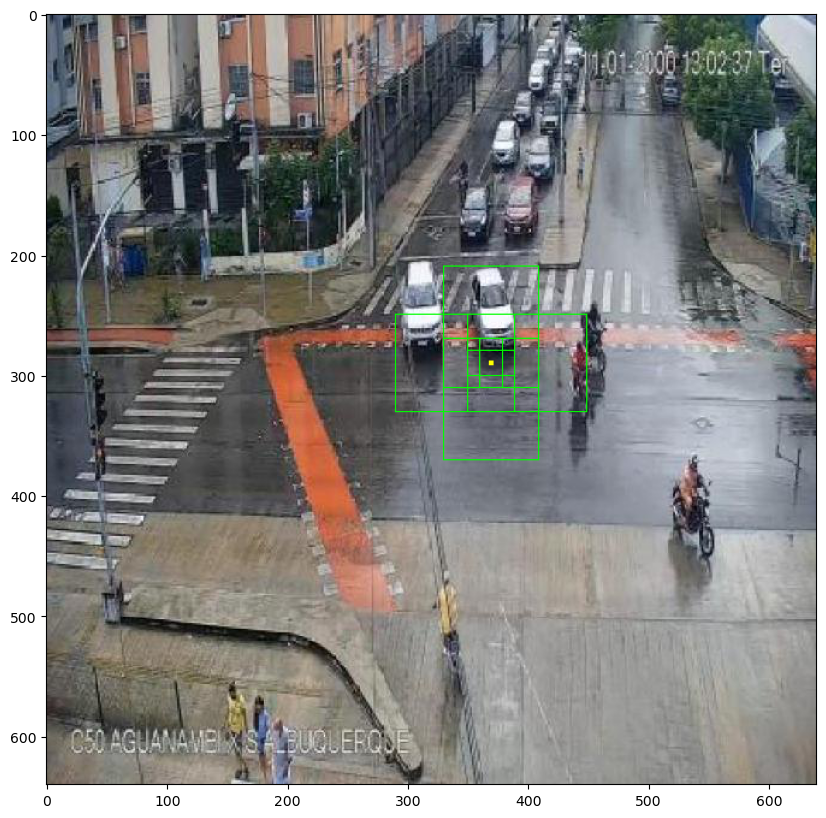

In [11]:
points = anchor_points
region_ratios = [[1, 1], [1, 2], [2, 1]]
region_scales = [5, 10, 20]
regions = generate_regions(points, region_ratios, region_scales)

# Test Points
test_points = [points[1800]]
test_regions = generate_regions(test_points, region_ratios, region_scales)
regioned_image = add_regions(image, test_regions, [0, 255, 0], 1)
regioned_image = add_anchor_points(regioned_image, test_points, 2)
plt.figure(figsize=(10, 10))
plt.imshow(regioned_image)

In [12]:
print(f'Anchor Points: {len(anchor_points)}')
print(f'Regions: {len(regions)}')
print(f'Regions Calculation: {len(anchor_points) * len(region_ratios) * len(region_scales)}')

Anchor Points: 3969
Regions: 35721
Regions Calculation: 35721


In [13]:
# Generating Masks for each object in the image
def generate_masks(image, x, y, width, height):
    mask = np.zeros(image.shape)
    mask[y - height : y + height, x - width : x + width, :] = [1, 1, 1]
    return mask

In [14]:
masks = []
regions_masks = []
for coords in object_coordinates:
    masks.append(generate_masks(image, coords[1], coords[2], coords[3], coords[4]))

for region in regions:
    regions_masks.append(generate_masks(image, region[0], region[1], region[2], region[3]))

MemoryError: Unable to allocate 9.38 MiB for an array with shape (640, 640, 3) and data type float64

In [114]:
demo_mask1 = np.zeros(image.shape)
demo_mask2 = np.zeros(image.shape)
demo_mask1[250:300, 250:300, :] = [1, 1, 1]
demo_mask2[310:360, 310:360, :] = [1, 1, 1]
new_mask = demo_mask1[demo_mask2 == 1]
new_mask = new_mask[new_mask == 1]
mask1 = demo_mask1[demo_mask1 == 1]
mask2 = demo_mask2[demo_mask2 == 1]
intersection_area = new_mask.shape[0] / 3
total_area = mask1.shape[0] / 3 + mask2.shape[0] / 3 - intersection_area
intersection_area, total_area

(0.0, 5000.0)

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32):
        self.folder = folder
        self.batch_size = batch_size
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
    
    def __len__(self):
        return self.images.__len__()
    
    def __getitem__(self, index):
        X = []
        y = []
        for i in range(index, index + self.batch_size):
            image = plt.imread(f'{self.folder}/images/{self.images[i]}')
            label = open(f'{self.folder}/labels/{self.labels[i]}').readlines()

Found 5805 files belonging to 2 classes.
